Importing necessary libraries


In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob as gb
import cv2 as cv
import glob as gb
import keras
#import matplotlib.pylab as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, MaxPool2D, AveragePooling2D, Flatten, Dropout,Activation,BatchNormalization,GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as k
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint
from tensorflow.keras import callbacks, layers, Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Model, layers, Sequential, optimizers
from tensorflow import keras
import keras.backend as K
from tensorflow.keras.applications import ResNet152V2
# from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

Loading Dataset from drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
Root = "/content/drive/MyDrive/Colab Notebooks/new plant dataset"
os.chdir(Root)

In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
EPOCH = 10

In [5]:
base_dir ="/content/drive/MyDrive/Colab Notebooks/new plant dataset"
train_dir = os.path.join(base_dir,"train")
valid_dir = os.path.join(base_dir,"valid")
test_dir = os.path.join(base_dir,"test")
diseases = os.listdir(train_dir)# printing the disease names
print(diseases)

['Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Bacterial_spot', 'Tomato___Late_blight', 'Tomato___healthy', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Early_blight']


In [6]:
print(len(diseases))

10


In [7]:
# with this code:  TensorFlow will only output log messages with a severity level of 'WARNING' or higher.
tf.get_logger().setLevel('WARNING')

Data Augmentation using ImageDataGeneratorAPI

In [8]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1/255.0,
    shear_range = 0.2,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    fill_mode="nearest")


validation_datagen =  keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)
test_datagen =  keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)

In [9]:
train_dir

'/content/drive/MyDrive/Colab Notebooks/new plant dataset/train'

In [10]:
# Define the generator instances
# generates batches of augmented data from the specified directory, allowing you to iterate over the training dataset during model training.
# handle large dataset and apply data augmentation methods
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",

)

val_data = validation_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)
test_data = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)

Found 18345 images belonging to 10 classes.
Found 4585 images belonging to 10 classes.
Found 0 images belonging to 0 classes.


In [11]:
print("Number of batches in training generator:", len(train_data))
print("Number of batches in validation generator:", len(val_data))

Number of batches in training generator: 574
Number of batches in validation generator: 144


In [12]:
# get sample from training data generator
sample_batch = next(train_data)

# Extract images and labels from the batch
images, labels = sample_batch

# Print the shape of images and labels
print("Shape of images in the batch:", images.shape)
print("Shape of labels in the batch:", labels.shape)

Shape of images in the batch: (32, 224, 224, 3)
Shape of labels in the batch: (32, 10)


Test Data Preprocessing


In [13]:
X_test=[]
y_test=[]

In [14]:
X_test=[]
for folder in os.listdir(test_dir):
    files=gb.glob(test_dir+'/*.JPG')
    for file in files :
        img=cv.imread(file)
        X_test.append(cv.resize(img,(IMAGE_SIZE,IMAGE_SIZE)))

In [15]:
X_test=np.array(X_test)
print(X_test.shape)

(256, 224, 224, 3)


In [16]:
X_test=X_test/255.0

Visualize the data

In [17]:
# Retrieve a batch of images and labels
images, labels = next(train_data)

In [18]:
classes=list(train_data.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in train_data:

    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
    # show the plot
    plt.show()
    break

Output hidden; open in https://colab.research.google.com to view.

In [19]:
# Number of images for each disease
diseases = os.listdir(train_dir)
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))

# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Tomato___Tomato_mosaic_virus,1790
Tomato___Tomato_Yellow_Leaf_Curl_Virus,1961
Tomato___Spider_mites Two-spotted_spider_mite,1741
Tomato___Target_Spot,1827
Tomato___Bacterial_spot,1702
Tomato___Late_blight,1851
Tomato___healthy,1926
Tomato___Leaf_Mold,1882
Tomato___Septoria_leaf_spot,1745
Tomato___Early_blight,1920


Text(0.5, 1.0, 'Images per each class of plant disease')

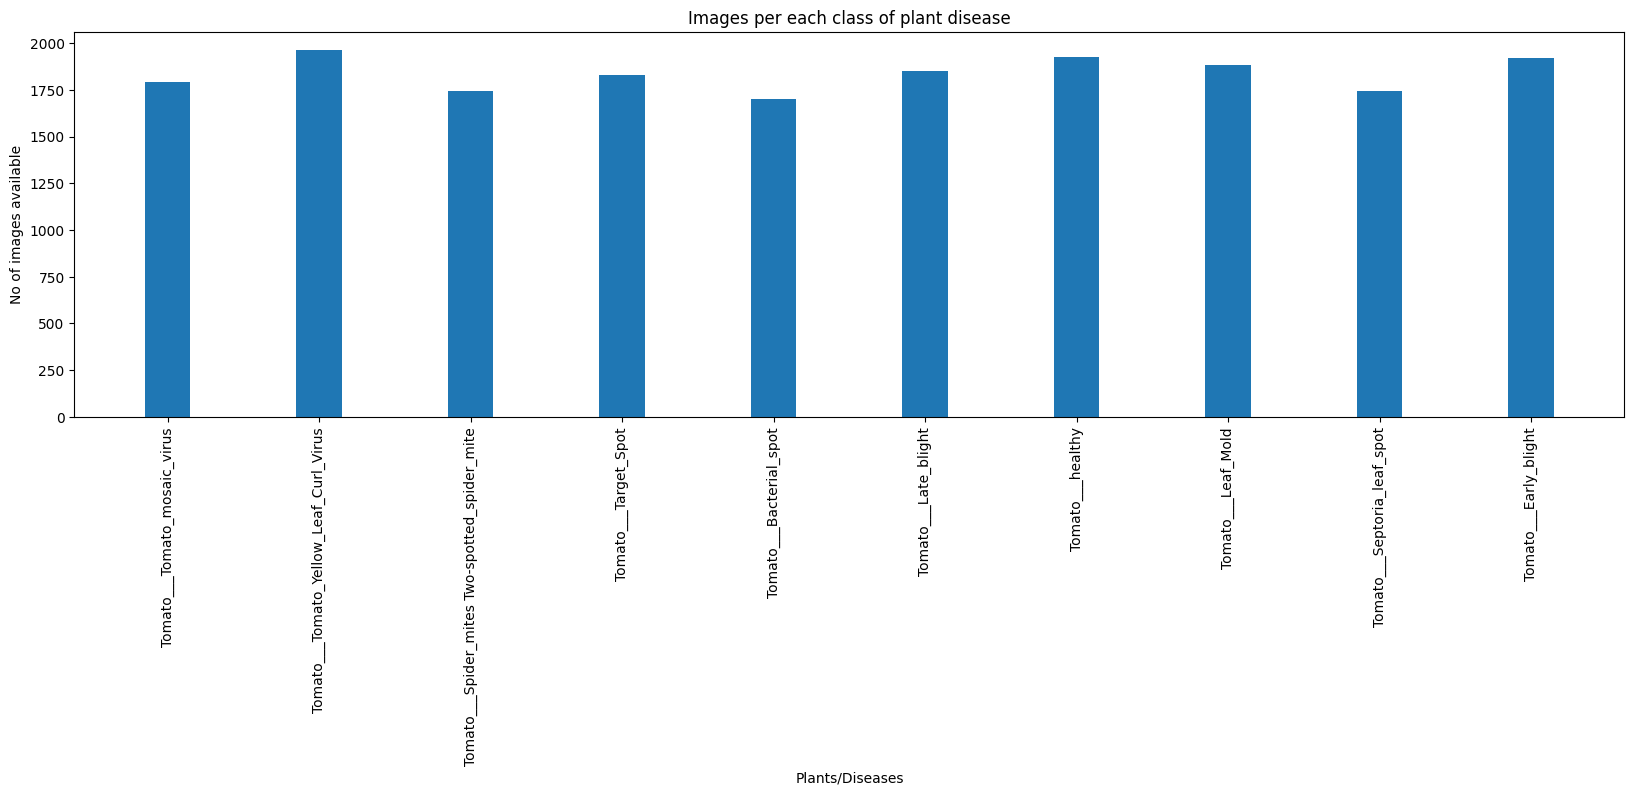

In [20]:
# plotting number of images available for each disease
index = [n for n in range(10)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=10, rotation=90)
plt.title('Images per each class of plant disease')

In [21]:
categories = list(train_data.class_indices.keys())
print(train_data.class_indices)

{'Tomato___Bacterial_spot': 0, 'Tomato___Early_blight': 1, 'Tomato___Late_blight': 2, 'Tomato___Leaf_Mold': 3, 'Tomato___Septoria_leaf_spot': 4, 'Tomato___Spider_mites Two-spotted_spider_mite': 5, 'Tomato___Target_Spot': 6, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7, 'Tomato___Tomato_mosaic_virus': 8, 'Tomato___healthy': 9}


defining callback function

In [22]:
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('model.h5',monitor='val_loss',verbose=1,save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

checking GPU available

In [ ]:
#tf.debugging.set_log_device_placement(True)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
#Check the gpus
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
# Create a MirroredStrategy.
#tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
print("Number of devices: {}".format(strategy.num_replicas_in_sync))# Define strategy

Number of devices: 1


## TRANSFER LEARNING MODEL with MOBILENET

In [ ]:
with strategy.scope():
    base_model = tf.keras.applications.MobileNet(weights = "imagenet",
                                             include_top = False,
                                             input_shape = INPUT_SHAPE)

    base_model.trainable = False
    inputs = keras.Input(shape = INPUT_SHAPE)

    x = base_model(inputs, training = False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(len(categories),
                              activation="softmax")(x)

    model = keras.Model(inputs = inputs,
                        outputs = x,
                        name="LeafDisease_MobileNet")
    optimizer = tf.keras.optimizers.Adam()

    model.compile(optimizer = optimizer,
                  loss = tf.keras.losses.CategoricalCrossentropy(),
                  metrics=[keras.metrics.CategoricalAccuracy(),
                           'accuracy'])

    history = model.fit(train_data,
                    validation_data=val_data,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCH,
                    steps_per_epoch=150,
                    validation_steps=100,
                    callbacks=[callback])

17225924/17225924 [==============================] - 0s 0us/step
Epoch 1/10
150/150 [==============================] - ETA: 0s - loss: 1.4785 - categorical_accuracy: 0.4952 - accuracy: 0.4952
Epoch 1: val_loss improved from inf to 0.80360, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 [==============================] - 2241s 15s/step - loss: 1.4785 - categorical_accuracy: 0.4952 - accuracy: 0.4952 - val_loss: 0.8036 - val_categorical_accuracy: 0.7541 - val_accuracy: 0.7541 - lr: 0.0010
Epoch 2/10
150/150 [==============================] - ETA: 0s - loss: 0.8125 - categorical_accuracy: 0.7277 - accuracy: 0.7277
Epoch 2: val_loss improved from 0.80360 to 0.61547, saving model to model.h5
150/150 [==============================] - 1240s 8s/step - loss: 0.8125 - categorical_accuracy: 0.7277 - accuracy: 0.7277 - val_loss: 0.6155 - val_categorical_accuracy: 0.8000 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 3/10
 13/150 [=>............................] - ETA: 11:52 - loss: 0.7086 - categorical_accuracy: 0.7837 - accuracy: 0.7837

Model Accuarcy and Loss Check

In [ ]:
ModelLoss = model.evaluate(val_data)
ModelAccuracy = model.evaluate(val_data)
print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

In [ ]:
plt.plot(history.history['val_loss'],label='validation loss')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.legend()

In [ ]:
TransferLearning_accuracy = history.history['val_accuracy'][len(history.history['val_accuracy'])-1]

Prediction

In [ ]:
y_pred=model.predict(X_test)

In [ ]:
y_pred[0]

In [ ]:
predictions=y_pred.argmax(axis=1)

In [ ]:
classes

In [ ]:
predictions

In [ ]:
predictions[11]

In [ ]:
plt.imshow(X_test[4])
plt.title(classes[predictions[4]])
plt.show()

## VGG16


In [23]:
vgg16 = tf.keras.applications.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(INPUT_SHAPE)
)
vgg16.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [24]:
inputs = keras.Input(shape=(INPUT_SHAPE))

# Get the layer
x = vgg16(inputs, training = False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)

x = tf.keras.layers.Dense(len(categories), activation="softmax")(x)

VGG16 = Model(inputs=inputs, outputs=x)

In [25]:
VGG16.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history=VGG16.fit(train_data,
                  validation_data=val_data,
                  epochs=EPOCH,
                  batch_size=BATCH_SIZE,
                  steps_per_epoch=150,
                  validation_steps=100,
                  callbacks=callback)

Epoch 1/10
 14/150 [=>............................] - ETA: 45:10 - loss: 15.7832 - accuracy: 0.0938

Model Accuarcy and Loss Check

In [ ]:
ModelLoss = VGG16.evaluate(val_data)
ModelAccuracy = VGG16.evaluate(val_data)
print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

In [ ]:
plt.plot(history.history['val_loss'],label='validation loss')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.legend()

In [ ]:
vgg16_accuracy = history.history['val_accuracy'][len(history.history['val_accuracy'])-1]

Prediction

In [ ]:
y_pred=model.predict(X_test)

In [ ]:
y_pred[0]

In [ ]:
predictions=y_pred.argmax(axis=1)

In [ ]:
classes

In [ ]:
predictions

In [ ]:
predictions[11]

In [ ]:
plt.imshow(X_test[4])
plt.title(classes[predictions[4]])
plt.show()

## INCEPTION V3


In [ ]:
inception_model = InceptionV3(input_shape= (INPUT_SHAPE),
                                include_top = False,
                                weights = "imagenet")



for layer in inception_model.layers:
    layer.trainable = False


# Taking output from 'mixed8' layer
last_layer = inception_model.get_layer('mixed9')
print('Last Layer Output Shape:', last_layer.output_shape)
last_output = last_layer.output


x = layers.Flatten()(last_output)

x = layers.Dense(2048, activation='relu')(x)

x = layers.Dense(1024, activation='relu')(x)

x = layers.Dropout(0.2)(x)

x = layers.Dense(len(categories), activation='softmax')(x)

inception3 = Model(inception_model.input, x)


87910968/87910968 [==============================] - 0s 0us/step
Last Layer Output Shape: (None, 5, 5, 2048)


In [ ]:
inception3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history=inception3.fit(train_data,
                       validation_data=val_data,
                       epochs=EPOCH,
                       batch_size=BATCH_SIZE,
                       steps_per_epoch=150,
                       validation_steps=100,
                       callbacks=callback)

Epoch 1/10
150/150 [==============================] - ETA: 0s - loss: 1.5129 - accuracy: 0.6121
Epoch 1: val_loss improved from inf to 0.59717, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 [==============================] - 2167s 14s/step - loss: 1.5129 - accuracy: 0.6121 - val_loss: 0.5972 - val_accuracy: 0.7900 - lr: 0.0010
Epoch 2/10
150/150 [==============================] - ETA: 0s - loss: 0.6087 - accuracy: 0.7885
Epoch 2: val_loss improved from 0.59717 to 0.40507, saving model to model.h5
150/150 [==============================] - 1540s 10s/step - loss: 0.6087 - accuracy: 0.7885 - val_loss: 0.4051 - val_accuracy: 0.8644 - lr: 0.0010
Epoch 3/10
150/150 [==============================] - ETA: 0s - loss: 0.5168 - accuracy: 0.8263
Epoch 3: val_loss improved from 0.40507 to 0.39548, saving model to model.h5
150/150 [==============================] - 1550s 10s/step - loss: 0.5168 - accuracy: 0.8263 - val_loss: 0.3955 - val_accuracy: 0.8666 - lr: 0.0010
Epoch 4/10
150/150 [==============================] - ETA: 0s - loss: 0.4459 - accuracy: 0.8519
Epoch 4: val_loss improved from 0.39548 to 0.38612, saving model to model.h5
150/150 [==============================]

In [ ]:
ModelLoss = inception3.evaluate(val_data)
ModelAccuracy = inception3.evaluate(val_data)
print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy))

144/144 [==============================] - 594s 4s/step - loss: 0.3336 - accuracy: 0.8931
Test Loss is [0.3336464464664459, 0.8931297659873962]
Test Accuracy is [0.33364641666412354, 0.8931297659873962]


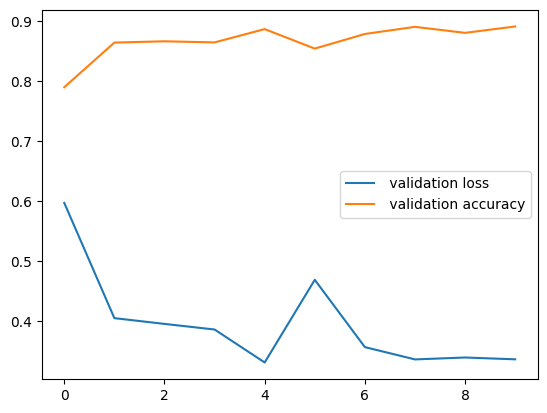

In [ ]:
plt.plot(history.history['val_loss'],label=' validation loss')
plt.plot(history.history['val_accuracy'],label=' validation accuracy')
plt.legend()

In [ ]:
inceptionv3_accuracy = history.history['val_accuracy'][len(history.history['val_accuracy'])-1]

Prediction

In [ ]:
y_pred=inception3.predict(X_test)

8/8 [==============================] - 43s 5s/step


In [ ]:
y_pred[0]

array([3.6973237e-05, 6.7219458e-04, 2.1388636e-05, 4.7005506e-05,
       1.2015714e-04, 7.5948318e-03, 9.8478788e-01, 1.6357842e-05,
       1.1461375e-04, 6.5885787e-03], dtype=float32)

In [ ]:
classes

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [ ]:
predictions

array([6, 3, 9, 1, 1, 1, 7, 1, 7, 0, 7, 1, 3, 6, 1, 7, 6, 3, 9, 1, 1, 1,
       7, 1, 7, 0, 7, 1, 3, 6, 1, 7, 6, 3, 9, 1, 1, 1, 7, 1, 7, 0, 7, 1,
       3, 6, 1, 7, 6, 3, 9, 1, 1, 1, 7, 1, 7, 0, 7, 1, 3, 6, 1, 7, 6, 3,
       9, 1, 1, 1, 7, 1, 7, 0, 7, 1, 3, 6, 1, 7, 6, 3, 9, 1, 1, 1, 7, 1,
       7, 0, 7, 1, 3, 6, 1, 7, 6, 3, 9, 1, 1, 1, 7, 1, 7, 0, 7, 1, 3, 6,
       1, 7, 6, 3, 9, 1, 1, 1, 7, 1, 7, 0, 7, 1, 3, 6, 1, 7, 6, 3, 9, 1,
       1, 1, 7, 1, 7, 0, 7, 1, 3, 6, 1, 7, 6, 3, 9, 1, 1, 1, 7, 1, 7, 0,
       7, 1, 3, 6, 1, 7, 6, 3, 9, 1, 1, 1, 7, 1, 7, 0, 7, 1, 3, 6, 1, 7,
       6, 3, 9, 1, 1, 1, 7, 1, 7, 0, 7, 1, 3, 6, 1, 7, 6, 3, 9, 1, 1, 1,
       7, 1, 7, 0, 7, 1, 3, 6, 1, 7, 6, 3, 9, 1, 1, 1, 7, 1, 7, 0, 7, 1,
       3, 6, 1, 7, 6, 3, 9, 1, 1, 1, 7, 1, 7, 0, 7, 1, 3, 6, 1, 7, 6, 3,
       9, 1, 1, 1, 7, 1, 7, 0, 7, 1, 3, 6, 1, 7])

In [ ]:
predictions[2]

9

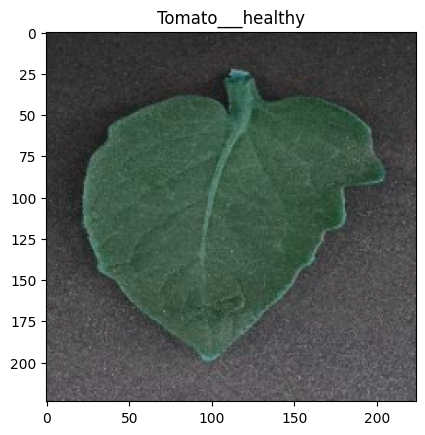

In [ ]:
plt.imshow(X_test[2])
plt.title(classes[predictions[2]])
plt.show()

## MOBILENET V2

In [ ]:
mbnet_v2 = tf.keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(INPUT_SHAPE)
)
mbnet_v2.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
inputs = keras.Input(shape=(INPUT_SHAPE))

# Get the layer
x = mbnet_v2(inputs, training = False)

# Stack layers further
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)

x = tf.keras.layers.Dense(len(categories), activation="softmax")(x)


# Combine the model
mobilenet2 = Model(inputs=inputs, outputs=x)

# Summary
mobilenet2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 4096)              256905216 
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_2 (Dense)             (None, 10)                40970     
                                                             

In [ ]:
mobilenet2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history=mobilenet2.fit(train_data,
                       validation_data=val_data,
                       epochs=EPOCH,
                       batch_size=BATCH_SIZE,
                       steps_per_epoch=150,
                       validation_steps=100,
                       callbacks=callback)

Epoch 1/10
150/150 [==============================] - ETA: 0s - loss: 8.3177 - accuracy: 0.5577
Epoch 1: val_loss improved from inf to 0.97510, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 [==============================] - 2205s 14s/step - loss: 8.3177 - accuracy: 0.5577 - val_loss: 0.9751 - val_accuracy: 0.6862 - lr: 0.0010
Epoch 2/10
150/150 [==============================] - ETA: 0s - loss: 0.8133 - accuracy: 0.7356
Epoch 2: val_loss improved from 0.97510 to 0.88102, saving model to model.h5
150/150 [==============================] - 1356s 9s/step - loss: 0.8133 - accuracy: 0.7356 - val_loss: 0.8810 - val_accuracy: 0.7178 - lr: 0.0010
Epoch 3/10
150/150 [==============================] - ETA: 0s - loss: 0.7347 - accuracy: 0.7615
Epoch 3: val_loss improved from 0.88102 to 0.61938, saving model to model.h5
150/150 [==============================] - 1303s 9s/step - loss: 0.7347 - accuracy: 0.7615 - val_loss: 0.6194 - val_accuracy: 0.8037 - lr: 0.0010
Epoch 4/10
150/150 [==============================] - ETA: 0s - loss: 0.5281 - accuracy: 0.8160
Epoch 4: val_loss improved from 0.61938 to 0.44997, saving model to model.h5
150/150 [==============================] -

Model Accuracy and Loss Check

In [ ]:
ModelLoss = mobilenet2.evaluate(val_data)
ModelAccuracy = mobilenet2.evaluate(val_data)
print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy))

144/144 [==============================] - 271s 2s/step - loss: 0.4740 - accuracy: 0.8434
Test Loss is [0.4740212559700012, 0.8434023857116699]
Test Accuracy is [0.474021315574646, 0.8434023857116699]


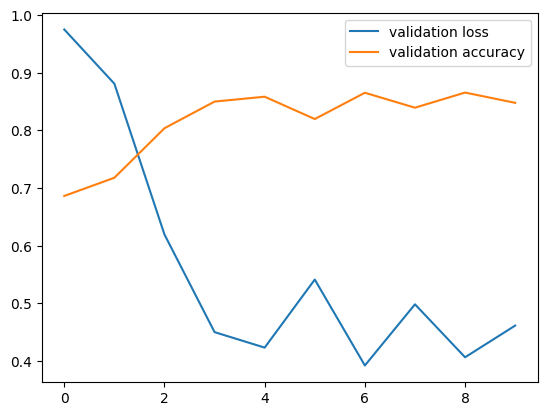

In [ ]:
plt.plot(history.history['val_loss'],label='validation loss')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.legend()

In [ ]:
mobilenetv2_accuracy = history.history['val_accuracy'][len(history.history['val_accuracy'])-1]

Prediction

In [ ]:
y_pred=mobilenet2.predict(X_test)

8/8 [==============================] - 16s 2s/step


In [ ]:
y_pred[0]

array([1.6131384e-04, 7.0858113e-02, 2.1603538e-03, 4.6749433e-04,
       6.4852596e-03, 4.8212174e-04, 1.1257896e-01, 1.1582702e-04,
       4.8154830e-03, 8.0187511e-01], dtype=float32)

In [ ]:
predictions=y_pred.argmax(axis=1)

In [ ]:
classes

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [ ]:
predictions

array([9, 8, 9, 1, 1, 1, 7, 3, 7, 1, 7, 3, 1, 9, 1, 3, 9, 8, 9, 1, 1, 1,
       7, 3, 7, 1, 7, 3, 1, 9, 1, 3, 9, 8, 9, 1, 1, 1, 7, 3, 7, 1, 7, 3,
       1, 9, 1, 3, 9, 8, 9, 1, 1, 1, 7, 3, 7, 1, 7, 3, 1, 9, 1, 3, 9, 8,
       9, 1, 1, 1, 7, 3, 7, 1, 7, 3, 1, 9, 1, 3, 9, 8, 9, 1, 1, 1, 7, 3,
       7, 1, 7, 3, 1, 9, 1, 3, 9, 8, 9, 1, 1, 1, 7, 3, 7, 1, 7, 3, 1, 9,
       1, 3, 9, 8, 9, 1, 1, 1, 7, 3, 7, 1, 7, 3, 1, 9, 1, 3, 9, 8, 9, 1,
       1, 1, 7, 3, 7, 1, 7, 3, 1, 9, 1, 3, 9, 8, 9, 1, 1, 1, 7, 3, 7, 1,
       7, 3, 1, 9, 1, 3, 9, 8, 9, 1, 1, 1, 7, 3, 7, 1, 7, 3, 1, 9, 1, 3,
       9, 8, 9, 1, 1, 1, 7, 3, 7, 1, 7, 3, 1, 9, 1, 3, 9, 8, 9, 1, 1, 1,
       7, 3, 7, 1, 7, 3, 1, 9, 1, 3, 9, 8, 9, 1, 1, 1, 7, 3, 7, 1, 7, 3,
       1, 9, 1, 3, 9, 8, 9, 1, 1, 1, 7, 3, 7, 1, 7, 3, 1, 9, 1, 3, 9, 8,
       9, 1, 1, 1, 7, 3, 7, 1, 7, 3, 1, 9, 1, 3])

In [ ]:
predictions[6]

7

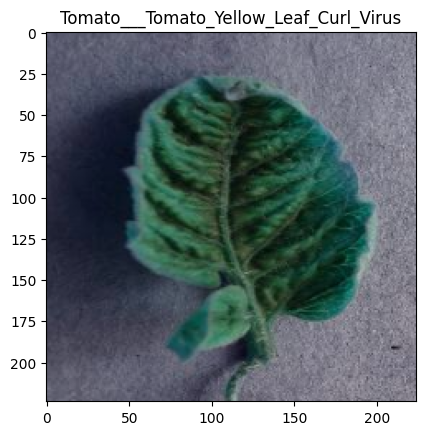

In [ ]:
plt.imshow(X_test[6])
plt.title(classes[predictions[6]])
plt.show()

## CNN


In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

cnn = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(categories), activation='softmax'),
])

cnn.build(input_shape=input_shape)

In [ ]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 111, 111, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 54, 54, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 52, 52, 64)         

In [ ]:
cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = cnn.fit(
    train_data,
    batch_size=BATCH_SIZE,
    validation_data=val_data,
    steps_per_epoch=150,
    validation_steps=100,
    epochs=EPOCH,
    callbacks=callback)

Epoch 1/10
150/150 [==============================] - ETA: 0s - loss: 2.3020 - accuracy: 0.1048
Epoch 1: val_loss did not improve from 0.39210
150/150 [==============================] - 630s 4s/step - loss: 2.3020 - accuracy: 0.1048 - val_loss: 2.3018 - val_accuracy: 0.1013 - lr: 0.0010
Epoch 2/10
150/150 [==============================] - ETA: 0s - loss: 2.3020 - accuracy: 0.1023
Epoch 2: val_loss did not improve from 0.39210
150/150 [==============================] - 670s 4s/step - loss: 2.3020 - accuracy: 0.1023 - val_loss: 2.3017 - val_accuracy: 0.1047 - lr: 0.0010
Epoch 3/10
150/150 [==============================] - ETA: 0s - loss: 2.3022 - accuracy: 0.1027
Epoch 3: val_loss did not improve from 0.39210
150/150 [==============================] - 664s 4s/step - loss: 2.3022 - accuracy: 0.1027 - val_loss: 2.3017 - val_accuracy: 0.1075 - lr: 0.0010
Epoch 4/10
150/150 [==============================] - ETA: 0s - loss: 2.3021 - accuracy: 0.1068
Epoch 4: val_loss did not improve from 0

Model Accuracy and Loss Check

In [ ]:
ModelLoss = cnn.evaluate(val_data)
ModelAccuracy = cnn.evaluate(val_data)
print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

144/144 [==============================] - 152s 1s/step - loss: 2.3020 - accuracy: 0.1049
Test Loss is [2.3019983768463135, 0.10490730404853821]
Test Accuracy is [2.3019983768463135, 0.10490730404853821]


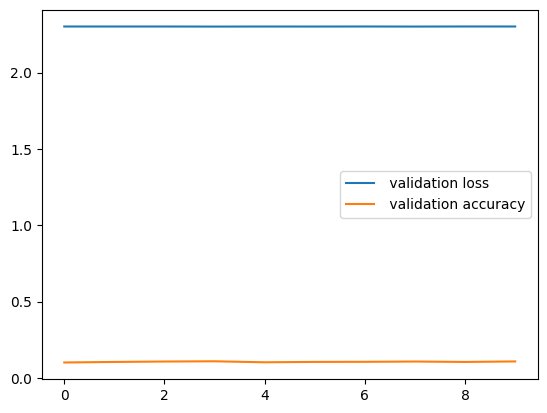

In [ ]:
plt.plot(history.history['val_loss'],label=' validation loss')
plt.plot(history.history['val_accuracy'],label=' validation accuracy')
plt.legend()

In [ ]:
CNN_accuracy = history.history['val_accuracy'][len(history.history['val_accuracy'])-1]

Prediction

In [ ]:
y_pred=cnn.predict(X_test)

8/8 [==============================] - 9s 1s/step


In [ ]:
y_pred[0]

array([0.09722343, 0.10021522, 0.0990563 , 0.09846836, 0.09717753,
       0.09693414, 0.0979415 , 0.10512415, 0.09889493, 0.10896455],
      dtype=float32)

In [ ]:
predictions=y_pred.argmax(axis=1)

In [ ]:
classes

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [ ]:
predictions

array([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [ ]:
predictions[5]

9

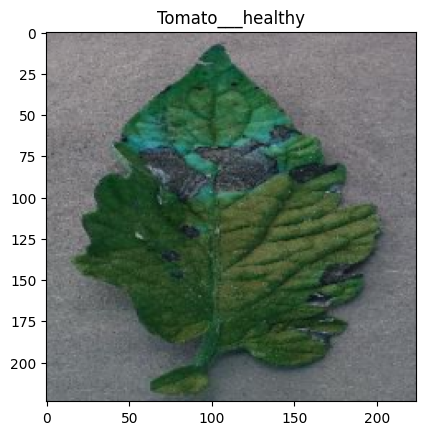

In [ ]:
plt.imshow(X_test[5])
plt.title(classes[predictions[5]])
plt.show()

## EFFICIENT NET

In [ ]:
image_shape = INPUT_SHAPE

base_model = tf.keras.applications.EfficientNetB0(include_top=False,)
base_model.trainable = False

inputs =  layers.Input(shape = image_shape,name='input_layer')

x = base_model(inputs)

x = layers.GlobalAveragePooling2D(name='GlobalAveragePooling2D_layer')(x)

outputs = layers.Dense(len(categories),activation='softmax',name='output_layer')(x)

feature_model = tf.keras.Model(inputs,outputs,name='plant_disease_model')

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-20]:
  layer.trainable = False

feature_model.compile(loss='categorical_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=['accuracy'])

In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['normalization[0

In [ ]:
feature_model.summary()

Model: "plant_disease_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 GlobalAveragePooling2D_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 1363770 (5.20 MB)
Non-trainable params: 2698611 (10.29 MB)
___

In [ ]:
history= feature_model.fit(train_data,
                           epochs=EPOCH,
                           batch_size=BATCH_SIZE,
                           steps_per_epoch=150,
                           validation_data=val_data,
                           validation_steps=100,
                           callbacks=callback)

Epoch 1/10
150/150 [==============================] - ETA: 0s - loss: 2.3545 - accuracy: 0.1033
Epoch 1: val_loss improved from inf to 2.31922, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 [==============================] - 2064s 14s/step - loss: 2.3545 - accuracy: 0.1033 - val_loss: 2.3192 - val_accuracy: 0.0997 - lr: 0.0010
Epoch 2/10
150/150 [==============================] - ETA: 0s - loss: 2.3201 - accuracy: 0.1037
Epoch 2: val_loss did not improve from 2.31922
150/150 [==============================] - 1278s 9s/step - loss: 2.3201 - accuracy: 0.1037 - val_loss: 2.3913 - val_accuracy: 0.0966 - lr: 0.0010
Epoch 3/10
150/150 [==============================] - ETA: 0s - loss: 2.3111 - accuracy: 0.1109
Epoch 3: val_loss did not improve from 2.31922
150/150 [==============================] - 1020s 7s/step - loss: 2.3111 - accuracy: 0.1109 - val_loss: 2.3465 - val_accuracy: 0.0956 - lr: 0.0010
Epoch 4/10
150/150 [==============================] - ETA: 0s - loss: 2.3061 - accuracy: 0.1144
Epoch 4: val_loss improved from 2.31922 to 2.28625, saving model to model.h5
150/150 [==============================] - 919s 6s/step - loss: 2.3061 - accuracy: 0.1144 - val_loss: 

Model Acccuracy and Loss Check

In [ ]:
ModelLoss = feature_model.evaluate(val_data)
ModelAccuracy = feature_model.evaluate(val_data)
print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

144/144 [==============================] - 333s 2s/step - loss: 4.4012 - accuracy: 0.0384
Test Loss is [4.401195526123047, 0.03838604316115379]
Test Accuracy is [4.401194095611572, 0.03838604316115379]


In [ ]:
plt.plot(history.history['val_loss'],label=' validation loss')
plt.plot(history.history['val_accuracy'],label=' validation accuracy')
plt.legend()

NameError: name 'history' is not defined

In [ ]:
EfficientNet_accuracy = history.history['val_accuracy'][len(history.history['val_accuracy'])-1]

Prediction

In [ ]:
y_pred=feature_model.predict(X_test)

NameError: name 'feature_model' is not defined

In [ ]:
y_pred[0]

array([0.3495114 , 0.02421738, 0.10738293, 0.0572192 , 0.06534758,
       0.00233075, 0.00162282, 0.2319052 , 0.00206039, 0.15840238],
      dtype=float32)

In [ ]:
predictions=y_pred.argmax(axis=1)

In [ ]:
classes

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [ ]:
predictions

array([0, 9, 9, 9, 0, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 9, 0, 9, 9, 9, 0, 9,
       9, 9, 9, 9, 9, 9, 0, 0, 0, 9, 0, 9, 9, 9, 0, 9, 9, 9, 9, 9, 9, 9,
       0, 0, 0, 9, 0, 9, 9, 9, 0, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 9, 0, 9,
       9, 9, 0, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 9, 0, 9, 9, 9, 0, 9, 9, 9,
       9, 9, 9, 9, 0, 0, 0, 9, 0, 9, 9, 9, 0, 9, 9, 9, 9, 9, 9, 9, 0, 0,
       0, 9, 0, 9, 9, 9, 0, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 9, 0, 9, 9, 9,
       0, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 9, 0, 9, 9, 9, 0, 9, 9, 9, 9, 9,
       9, 9, 0, 0, 0, 9, 0, 9, 9, 9, 0, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 9,
       0, 9, 9, 9, 0, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 9, 0, 9, 9, 9, 0, 9,
       9, 9, 9, 9, 9, 9, 0, 0, 0, 9, 0, 9, 9, 9, 0, 9, 9, 9, 9, 9, 9, 9,
       0, 0, 0, 9, 0, 9, 9, 9, 0, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 9, 0, 9,
       9, 9, 0, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 9])

In [ ]:
predictions[2]

9

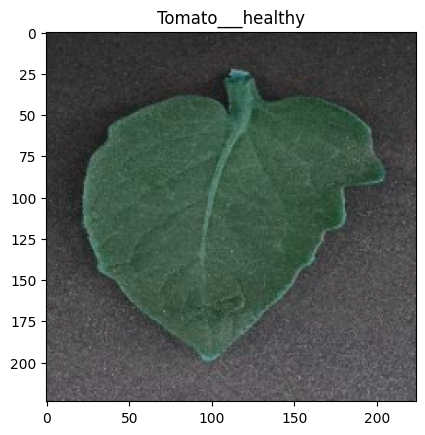

In [ ]:
plt.imshow(X_test[2])
plt.title(classes[predictions[2]])
plt.show()

## EfficientNet B3

In [ ]:
base_model = tf.keras.applications.EfficientNetB3(input_shape=(INPUT_SHAPE),  # Ensure input shape matches your image size and channels (3 for RGB)
                         include_top=False,             # Exclude the top classification layer
                         weights='imagenet',
                         pooling = 'max'
                        )

43941136/43941136 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
inputs = base_model.input

x = BatchNormalization()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Flatten()(x)

outputs = Dense(len(categories), activation='softmax')(x)
EfficientNetB3 = Model(inputs=inputs, outputs=outputs)

In [ ]:
EfficientNetB3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = EfficientNetB3.fit(train_data,
                    epochs=EPOCH,
                    batch_size=BATCH_SIZE,
                    steps_per_epoch=150,
                    validation_data=val_data,
                    validation_steps=100,
                    callbacks=callback)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-30-b7bceed12ac7>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2454, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5775, in sparse_categorical_crossentropy

logits and labels must have the same first dimension, got logits shape [32,10] and labels shape [320]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_24538]

Model Accuracy and Loss check

In [ ]:
ModelLoss = EfficientNetB3.evaluate(val_data)
ModelAccuracy = EfficientNetB3.evaluate(val_data)
print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

In [ ]:
plt.plot(history.history['val_loss'],label=' validation loss')
plt.plot(history.history['val_accuracy'],label=' validation accuracy')
plt.legend()

In [ ]:
EfficientNEtB3_accuracy = history.history['val_accuracy'][len(history.history['val_accuracy'])-1]

Prediction

In [ ]:
y_pred=EfficientNetB3.predict(X_test)

In [ ]:
y_pred[0]

In [ ]:
predictions=y_pred.argmax(axis=1)

In [ ]:
classes

In [ ]:
predictions

In [ ]:
predictions[11]

In [ ]:
plt.imshow(X_test[4])
plt.title(classes[predictions[4]])
plt.show()

## ResNet152v2

In [ ]:
#defining an function
def f1_macro(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives + K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives + K.epsilon())
        return precision

    def accuracy_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
        total_samples = K.cast(K.shape(y_true)[0], dtype='float32')

        accuracy = (true_positives + true_negatives) / total_samples
        return accuracy

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    accuracy = accuracy_m(y_true, y_pred)

    return {
        'f1_macro': 2 * ((precision * recall) / (precision + recall + K.epsilon())),
        'accuracy': accuracy
    }

In [ ]:
# Use pre-trained ResNet152V2 model as the base model
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(INPUT_SHAPE))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classifier on top of the pre-trained model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(categories), activation='softmax')(x)

# Create the model
resnet152v2_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
resnet152v2_model.compile(optimizer=Adam(learning_rate=0.001),
                          loss='categorical_crossentropy',
                          metrics=['accuracy', f1_macro])

# Display the model summary
resnet152v2_model.summary()

234545216/234545216 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                           

In [ ]:
resnet152v2_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = resnet152v2_model.fit(train_data,
                    epochs=EPOCH,
                    batch_size=BATCH_SIZE,
                    steps_per_epoch=150,
                    validation_data=val_data,
                    validation_steps=100,
                    callbacks=callback)

Epoch 1/10
150/150 [==============================] - ETA: 0s - loss: 1.3058 - accuracy: 0.5608 
Epoch 1: val_loss improved from inf to 0.72424, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 [==============================] - 3886s 26s/step - loss: 1.3058 - accuracy: 0.5608 - val_loss: 0.7242 - val_accuracy: 0.7625 - lr: 0.0010
Epoch 2/10
150/150 [==============================] - ETA: 0s - loss: 0.8567 - accuracy: 0.7098 
Epoch 2: val_loss improved from 0.72424 to 0.60940, saving model to model.h5
150/150 [==============================] - 3849s 26s/step - loss: 0.8567 - accuracy: 0.7098 - val_loss: 0.6094 - val_accuracy: 0.7916 - lr: 0.0010
Epoch 3/10
 77/150 [==============>...............] - ETA: 18:44 - loss: 0.7418 - accuracy: 0.7415

Model Accuracy and Loss Check

In [ ]:
ModelLoss = resnet152v2_model.evaluate(val_data)
ModelAccuracy = resnet152v2_model.evaluate(val_data)
print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

In [ ]:
plt.plot(history.history['val_loss'],label=' validation loss')
plt.plot(history.history['val_accuracy'],label=' validation accuracy')
plt.legend()

In [ ]:
ResNet152V2_accuracy = history.history['val_accuracy'][len(history.history['val_accuracy'])-1]

Prediction

In [ ]:
y_pred=resnet152v2_model.predict(X_test)

In [ ]:
y_pred[0]

In [ ]:
predictions=y_pred.argmax(axis=1)

In [ ]:
classes

In [ ]:
predictions

In [ ]:
predictions[11]

In [ ]:
plt.imshow(X_test[4])
plt.title(classes[predictions[4]])
plt.show()